In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
rfm_normalized = pd.read_csv("../data/datamart_normalized_df.csv")
rfm_normalized = rfm_normalized.set_index('CustomerID')

In [32]:
rfm = pd.read_csv("../data/rfm_datamart.csv")
rfm = rfm.set_index('CustomerID')

In [29]:
rfm_normalized.describe()

,Recency,Frequency,MonetaryValue
count,3.643000e+03,3.643000e+03,3.643000e+03
mean,-2.718225e-17,1.711962e-16,3.458057e-16
std,1.000137e+00,1.000137e+00,1.000137e+00
min,-2.814518e+00,-1.794731e+00,-4.093550e+00
25%,-6.373949e-01,-6.491795e-01,-6.579180e-01
50%,9.268036e-02,2.092505e-02,-1.489805e-02
75%,8.340401e-01,7.210817e-01,6.692948e-01
max,1.547876e+00,4.246826e+00,4.459466e+00


In [33]:
rfm.describe()

,Recency,Frequency,MonetaryValue
count,3643.00000,3643.000000,3643.000000
mean,90.43563,18.714247,370.694387
std,94.44651,43.754468,1347.443451
min,1.00000,1.000000,0.650000
25%,19.00000,4.000000,58.705000
50%,51.00000,9.000000,136.370000
75%,139.00000,21.000000,334.350000
max,365.00000,1497.000000,48060.350000


/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

<AxesSubplot:xlabel='MonetaryValue', ylabel='Density'>

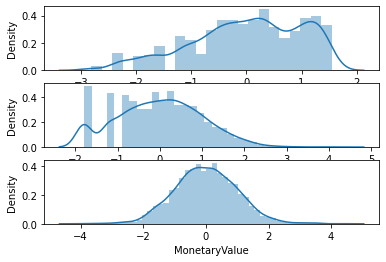

In [34]:
#Visualize Normalized Variables
plt.subplot(3,1,1); sns.distplot(rfm_normalized['Recency'])
plt.subplot(3,1,2); sns.distplot(rfm_normalized['Frequency'])
plt.subplot(3,1,3); sns.distplot(rfm_normalized['MonetaryValue'])

In [35]:
from sklearn.cluster import KMeans

In [36]:
sse = {}
for k in range(1, 21):
  
    # Initialize KMeans with k clusters
    kmeans = KMeans(n_clusters=k, random_state=1)
    
    # Fit KMeans on the normalized dataset
    kmeans.fit(rfm_normalized)
    
    # Assign sum of squared distances to k element of dictionary
    sse[k] = kmeans.inertia_

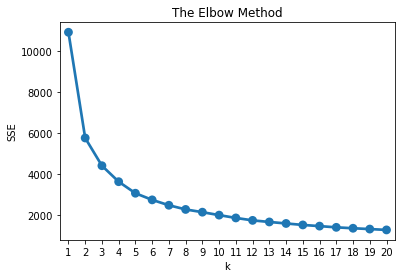

In [37]:
# Add the plot title "The Elbow Method"
plt.title('The Elbow Method')

# Add X-axis label "k"
plt.xlabel('k')

# Add Y-axis label "SSE"
plt.ylabel('SSE')

# Plot SSE values for each key in the dictionary
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [42]:
# Initialize KMeans with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=1)
    
# Fit KMeans on the normalized dataset
kmeans.fit(rfm_normalized)

KMeans(n_clusters=3, random_state=1)

In [43]:
cluster_labels = kmeans.labels_

In [44]:
rfm_k3 = rfm.assign(Cluster=cluster_labels)

In [45]:
grouped = rfm_k3.groupby(['Cluster'])

In [46]:
# Calculate average RFM values and segment sizes per cluster value
grouped.agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
  }).round(1)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          16.1      50.1        1050.6   901
1         166.6       3.0          53.0  1156
2          77.1      12.3         216.0  1586

In [48]:
#transform datamart_normalized as DataFrame and add a Cluster column
rfm_normalized = pd.DataFrame(rfm_normalized,
                                   index = rfm.index,
                                   columns = rfm.columns)
rfm_normalized['Cluster'] = rfm_k3['Cluster']

In [49]:
# Melt the normalized dataset and reset the index
rfm_melt = pd.melt(
  					rfm_normalized.reset_index(), 
                        
# Assign CustomerID and Cluster as ID variables
                    id_vars=['CustomerID', 'Cluster'],

# Assign RFM values as value variables
                    value_vars=['Recency', 'Frequency', 'MonetaryValue'], 
                        
# Name the variable and value
                    var_name='Attribute', value_name='Value'
					)

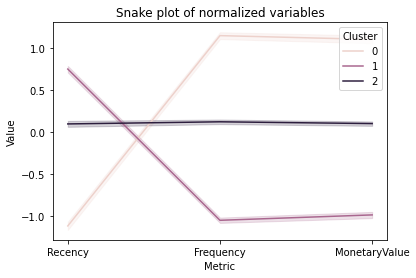

In [50]:
# Add the plot title
plt.title('Snake plot of normalized variables')

# Add the x axis label
plt.xlabel('Metric')

# Add the y axis label
plt.ylabel('Value')

# Plot a line for each value of the cluster variable
sns.lineplot(data=rfm_melt, x='Attribute', y='Value', hue='Cluster')
plt.show()

In [51]:
cluster_avg = rfm_k3.groupby(['Cluster']).mean()
population_avg = rfm.mean()
relative_imp = cluster_avg / population_avg - 1
print(relative_imp.round(2))

         Recency  Frequency  MonetaryValue
Cluster                                   
0          -0.82       1.68           1.83
1           0.84      -0.84          -0.86
2          -0.15      -0.34          -0.42


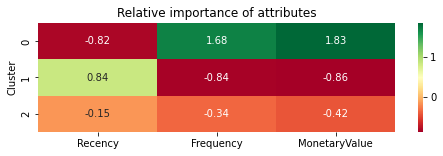

In [52]:
plt.figure(figsize = (8,2))
plt.title('Relative importance of attributes')
sns.heatmap(data = relative_imp, annot = True, fmt = '.2f', cmap = 'RdYlGn')
plt.show()